In [37]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import torch
from transformers import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "21st_year" # 21st_year, pieman
MODEL = 'gpt2' # bert-base-uncased, gpt2

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/21st_year/tr_tokens.csv
Loaded 2225 TRs.


# Layerwise Activations

In [38]:
foo.process_stimulus_activations()

Processed 2225 TRs for activations.


In [39]:
foo.model_name

'gpt2'

In [40]:
for layer in range(0, 13):

    layer_activations = foo.layer_activations_from_tensor(foo.stimulus_df["activations"], layer)
    layer_mean_embeddings = np.array([l.mean(0).numpy() for l in layer_activations])
    np.save("{}_{}_layer_{}_activations.npy".format(STIMULUS, MODEL, layer), layer_mean_embeddings)
    
    print(layer_mean_embeddings.shape)
    
#     df["layer_{}".format(layer)] = layer_mean_embeddings

(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)
(2225, 768)


# Syntactic Complexity

In [41]:
foo.process_stimulus_attentions()

In [42]:
foo.mask_non_tr_attentions()

In [43]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p=2)
foo.compute_attention_head_magnitudes(p='inf')

<AxesSubplot:>

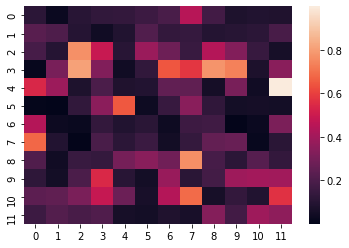

In [ ]:
sns.heatmap(foo.stimulus_df.attention_heads_Linf.iloc[18])

In [ ]:
# file_name = "{}-{}-full_df.pkl".format(STIMULUS, MODEL)
# foo.stimulus_df.to_pickle(file_name)

<AxesSubplot:>

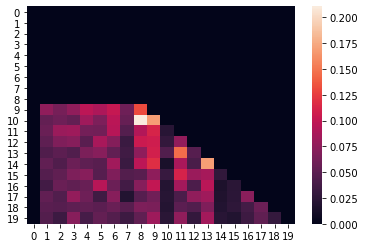

In [ ]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[10][0][11])

In [ ]:
foo.compute_attention_head_distances()

Processing TR 0.
Processing TR 100.
Processing TR 200.
Processing TR 300.
Processing TR 400.
Processing TR 500.
Processing TR 600.
Processing TR 700.
Processing TR 800.
Processing TR 900.
Processing TR 1000.
Processing TR 1100.
Processing TR 1200.
Processing TR 1300.
Processing TR 1400.
Processing TR 1500.
Processing TR 1600.
Processing TR 1700.
Processing TR 1800.
Processing TR 1900.
Processing TR 2000.
Processing TR 2100.
Processing TR 2200.


<AxesSubplot:>

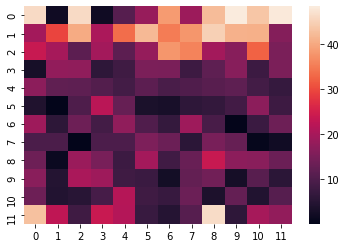

In [51]:
sns.heatmap(foo.stimulus_df.attention_distances.iloc[30])

In [37]:
# foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)
# file_name = "{}-{}-full_df.pkl".format(STIMULUS, MODEL)

# try:
#     df = pd.read_pickle(file_name)
#     foo.stimulus_df = df
       
# except:
    
#     foo.process_stimulus_attentions()
#     foo.process_stimulus_activations()
#     foo.mask_non_tr_attentions()
    
#     foo.compute_attention_head_magnitudes(p=1)
#     foo.compute_attention_head_magnitudes(p=2)
#     foo.compute_attention_head_magnitudes(p='inf')
    
#     foo.stimulus_df.to_pickle(file_name)


# Outputs for Sreejan

### Syntactic Complexity

In [52]:
import itertools

p='inf'

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))
foo.stimulus_df["attention_heads_L{}_vector".format(p)] = attention_vectors

for_output = foo.stimulus_df[["attention_heads_L{}_vector".format(p)]]
for_output.to_pickle("{}_{}_syntactic_complexity_L-{}.pkl".format(STIMULUS, MODEL, p), protocol=4)

In [53]:
baz = pd.read_pickle("{}_{}_syntactic_complexity_L-{}.pkl".format(STIMULUS, MODEL, p))
baz.head(10)

,attention_heads_Linf_vector
0,None
1,None
2,None
3,"[0.31454941630363464, 0.4685303270816803, 0.19..."
4,"[0.17557550966739655, 0.023231903091073036, 0...."
5,"[0.17436257004737854, 0.013357816264033318, 0...."
6,"[0.34451693296432495, 0.004543196875602007, 0...."
7,"[0.1751290261745453, 0.475515753030777, 0.1565..."
8,"[0.3493932783603668, 0.10825119912624359, 0.25..."
9,"[0.16315926611423492, 0.3441610336303711, 0.27..."


### Syntactic Distance

In [54]:
attention_vectors = foo.stimulus_df["attention_distances".format(p)].apply(lambda x: flatten(x))
foo.stimulus_df["attention_distances_vector"] = attention_vectors

for_output = foo.stimulus_df[["attention_distances_vector"]]
for_output.to_pickle("{}_{}_syntactic_distance.pkl".format(STIMULUS, MODEL), protocol=4)

In [55]:
pd.read_pickle("{}_{}_syntactic_distance.pkl".format(STIMULUS, MODEL)).head(10)

,attention_distances_vector
0,None
1,None
2,None
3,"[44.422900387551636, 5.305236877392815, 45.702..."
4,"[31.280838137492537, 0.4436186403603415, 31.45..."
5,"[25.56357154622674, 0.5178935651415486, 22.794..."
6,"[33.37947503384203, 0.3523415504332661, 34.221..."
7,"[27.779784557875246, 6.160844690740305, 27.814..."
8,"[54.58275112323463, 4.010526841484534, 42.4522..."
9,"[42.23731473181397, 6.380568041034394, 47.7979..."


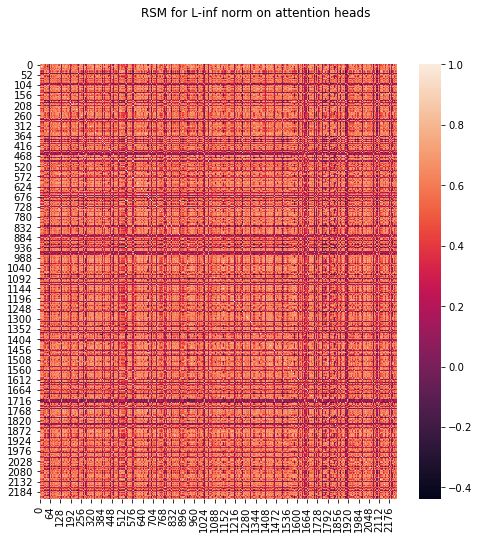

In [9]:
non_null = for_output[~pd.isnull(for_output["attention_heads_L{}_vector".format(p)])]

non_null_df = pd.DataFrame.from_records(non_null["attention_heads_L{}_vector".format(p)].values)

rsm_df = pd.DataFrame(np.corrcoef(non_null_df))

plt.figure(figsize=(8,8))
sns.heatmap(rsm_df)
plt.suptitle("RSM for L-inf norm on attention heads");

# Semantic Composition

(F.K.A "Attention Effects")

### End-to-end
How far do tokens "move in space" from the initial embeddings to final outputs?

`activation_end_to_end_l2_distances[n_token]` gives the start-to-finish displacement of the contextualization process. Longer distances indicates the token's meaning was changed more during contextualization.

In [56]:
foo.end_to_end_token_movement()

def normalize_col(col):
    
    de_meaned = col - col.mean()
    return de_meaned / de_meaned.std()

foo.stimulus_df["activation_end_to_end_mean_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.mean(x))
foo.stimulus_df["activation_end_to_end_max_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.max(x))

foo.stimulus_df.activation_end_to_end_mean_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_mean_l2)
foo.stimulus_df.activation_end_to_end_max_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_max_l2)

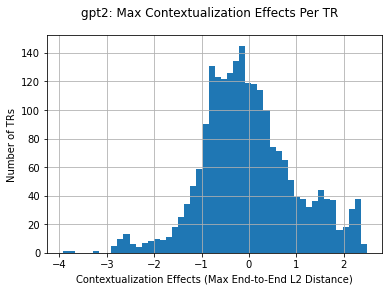

In [57]:
foo.stimulus_df.activation_end_to_end_max_l2.hist(bins=50)
plt.suptitle("{}: Max Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Max End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

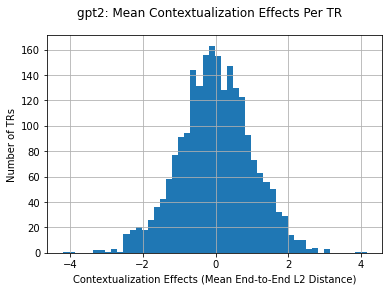

In [58]:
foo.stimulus_df.activation_end_to_end_mean_l2.hist(bins=50)
plt.suptitle("{}: Mean Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Mean End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

### Layerwise
How far do tokens move each layer?

`activation_layerwise_l2_distances[n_layer][n_token]` gives the L2 distance that each token moved, each layer.

We can look at the mean or max distance for each layer + token.

In [59]:
foo.layerwise_token_movement()

len(foo.stimulus_df["activation_layerwise_l2_distances"][0][0])

5

In [60]:
mean_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.mean(layer) for layer in x])
max_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.max(layer) for layer in x])

foo.stimulus_df["activation_layerwise_mean_l2"] = mean_l2_per_layer
foo.stimulus_df["activation_layerwise_max_l2"] = max_l2_per_layer

['what', ',', 'Ġ25', '?', 'Ġ26', '?']


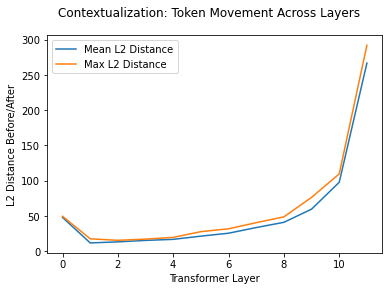

In [61]:
test = foo.stimulus_df.iloc[202]
print(test.transformer_tokens_in_tr)

plt.plot(test["activation_layerwise_mean_l2"], label="Mean L2 Distance")
plt.plot(test["activation_layerwise_max_l2"], label="Max L2 Distance")
plt.xlabel("Transformer Layer")
plt.ylabel("L2 Distance Before/After")
plt.legend(loc='best')
plt.suptitle("Contextualization: Token Movement Across Layers");

In [72]:
metric = "max" # mean, max

print("Mean / Std of Max L2 Displacement Across Layers: {}, {}".format(STIMULUS, MODEL))
df = pd.DataFrame.from_records(foo.stimulus_df["activation_layerwise_{}_l2".format(metric)])
df.apply([np.mean, np.std])

Mean / Std of Max L2 Displacement Across Layers: 21st_year, gpt2


,0,1,2,3,4,5,6,7,8,9,10,11
mean,54.91070,17.691284,19.434213,20.849686,21.247664,26.121433,29.601845,36.319815,42.476538,68.588687,105.123873,292.225647
std,5.02964,11.155251,49.023103,5.575754,4.745977,5.939189,4.687755,6.342678,5.624902,6.313149,14.120573,66.637816


In [73]:
normalized = (df-df.mean())/df.std()
normalized.apply([np.mean, np.std])
foo.stimulus_df["activation_layerwise_{}_l2_normed".format(metric)] = [list(r) for r in normalized.to_records(index=False)]

In [74]:
full_lists = []
for i, tr in foo.stimulus_df.iterrows():
    
    all_composition = tr["activation_layerwise_{}_l2_normed".format(metric)] + [tr['activation_end_to_end_{}_l2'.format(metric)]]
    full_lists.append(all_composition)
    
foo.stimulus_df["full_semantic_composition"] = full_lists

In [75]:
foo.stimulus_df.full_semantic_composition

0       [14.040125148349826, 45.64392244767657, 47.005...
1       [0.6890619559106852, -0.10354557795803947, -0....
2       [2.460611158603301, -0.11601769827496575, -0.0...
3       [0.43683707218898077, 0.07954635884790191, -0....
4       [2.1175217288520702, -0.13902300158163658, 0.0...
                              ...                        
2220    [-0.7447873154121047, -0.35131244493697805, -0...
2221    [-0.5219566618156075, 0.4046433981754423, -0.0...
2222    [1.2369758358988676, 0.3099929927723856, -0.01...
2223    [-0.5776332290377493, -0.051709610256771725, -...
2224    [-0.6692220884579652, -0.19003466444566067, -0...
Name: full_semantic_composition, Length: 2225, dtype: object

In [76]:
foo.stimulus_df.head()

,tr,tokens,tr.1,index,tr_shift,prev_tr,story_section,n_tokens,activations,transformer_tokens_in_tr,...,attention_distances_vector,activation_end_to_end_l2_distances,activation_end_to_end_mean_l2,activation_end_to_end_max_l2,activation_layerwise_l2_distances,activation_layerwise_mean_l2,activation_layerwise_max_l2,activation_layerwise_mean_l2_normed,full_semantic_composition,activation_layerwise_max_l2_normed
0,0,This is Los Angeles.,0,A1.1,NaN,NaN,A1,4,"[[[tensor(0.0065), tensor(-0.2930), tensor(0.0...","[This, Ġis, ĠLos, ĠAngeles, .]",...,None,"[78.17997741699219, 249.7174835205078, 135.136...",-1.726963,0.095285,"[[125.52748107910156, 50.91493606567383, 61.85...","[71.01051712036133, 117.54993553161621, 476.07...","[125.52748107910156, 526.8607177734375, 2323.7...","[12.006573251727332, 37.720654528158406, 45.96...","[14.040125148349826, 45.64392244767657, 47.005...","[14.040125148349826, 45.64392244767657, 47.005..."
1,1,And it's the height of summer.,1,A1.2,1.0,0.0,A1,6,"[[[tensor(0.0543), tensor(-0.0364), tensor(0.1...","[And, Ġit, 's, Ġthe, Ġheight, Ġof, Ġsummer, .]",...,None,"[301.6600646972656, 311.1525573730469, 226.122...",0.337963,0.410152,"[[54.01777648925781, 55.69797134399414, 55.499...","[54.66135109795464, 12.698774337768555, 13.584...","[58.376434326171875, 16.53620719909668, 17.454...","[2.7490245788368206, -0.39941662314181703, -0....","[0.6890619559106852, -0.10354557795803947, -0....","[0.6890619559106852, -0.10354557795803947, -0...."
2,2,In a small bungalow,2,A1.3,1.0,1.0,A1,4,"[[[tensor(0.0467), tensor(0.0059), tensor(0.12...","[In, Ġa, Ġsmall, Ġbung, al, ow]",...,None,"[316.2166442871094, 253.39239501953125, 267.08...",0.388863,0.695110,"[[51.973976135253906, 53.53099822998047, 53.44...","[54.433722904750276, 13.003622463771276, 15.05...","[67.28668975830078, 16.397077560424805, 18.515...","[2.6201324338170986, -0.2885849249398315, 0.05...","[2.460611158603301, -0.11601769827496575, -0.0...","[2.460611158603301, -0.11601769827496575, -0.0..."
3,3,"off of La Cienega,",3,A1.3,1.0,2.0,A1,4,"[[[tensor(-0.1379), tensor(-0.1583), tensor(-0...","[off, Ġof, ĠLa, ĠC, ien, ega, ,]",...,"[44.422900387551636, 5.305236877392815, 45.702...","[238.99073791503906, 108.45894622802734, 165.2...",-1.497525,-1.083450,"[[51.22111511230469, 49.768733978271484, 50.96...","[51.910871505737305, 13.165873765945435, 15.11...","[57.10783386230469, 18.578643798828125, 18.515...","[1.1915935353299416, -0.22959624886942315, 0.0...","[0.43683707218898077, 0.07954635884790191, -0....","[0.43683707218898077, 0.07954635884790191, -0...."
4,4,Clara serves homemade chili,4,A1.3,1.0,3.0,A1,4,"[[[tensor(0.0488), tensor(-0.0096), tensor(0.1...","[Cl, ara, Ġserves, Ġhomemade, Ġchili]",...,"[31.280838137492537, 0.4436186403603415, 31.45...","[183.30926513671875, 247.16583251953125, 209.3...",-0.931316,-1.083451,"[[53.6826171875, 50.659732818603516, 65.561073...","[57.7592887878418, 13.15824580192566, 15.57496...","[65.56107330322266, 16.14044761657715, 20.0607...","[4.503200229778713, -0.23236949933095888, 0.10...","[2.1175217288520702, -0.13902300158163658, 0.0...","[2.1175217288520702, -0.13902300158163658, 0.0..."


In [77]:
attention_effects_df = foo.stimulus_df[['full_semantic_composition']]
attention_effects_df.to_pickle("{}_{}_semantic_composition_{}_l2.pkl".format(STIMULUS, MODEL, metric), protocol=4)

<AxesSubplot:>

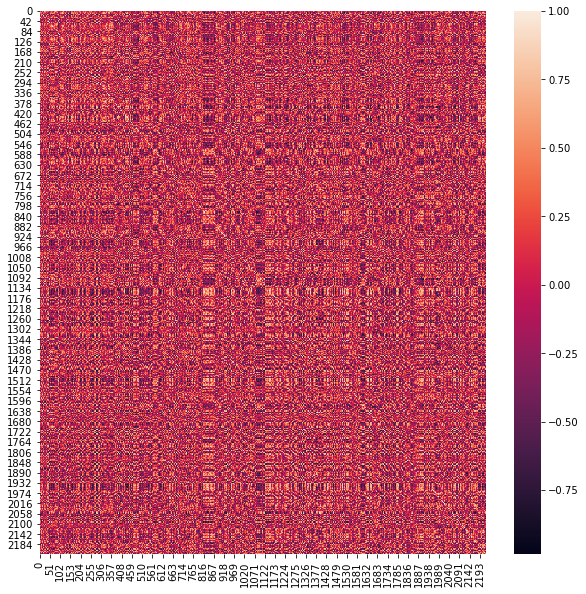

In [68]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(np.corrcoef(normalized)))

In [69]:
baz = pd.read_pickle("{}_{}_semantic_composition_max_l2.pkl".format(STIMULUS, MODEL))
baz.head()

FileNotFoundError: [Errno 2] No such file or directory: '21st_year_gpt2_semantic_composition_max_l2.pkl'

### To upload to PNI

```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [71]:
scp = "tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"
print(scp.format(STIMULUS, MODEL))



tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/21st_year/gpt2/syntactic_analyses


In [ ]:
scp 21st_year_gpt2_syntactic_complexity_L-inf.pkl tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/21st_year/bert-base-uncased/syntactic_analyses/

In [70]:
print("{}_{}_syntactic_distance.pkl".format(STIMULUS, MODEL))

21st_year_bert-base-uncased_syntactic_distance.pkl


In [ ]:
scp 21st_year_gpt2_layer_*_activations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/21st_year/gpt2/raw_embeddings